This notebook was inspired by neural network & machine learning labs led by [GMUM](https://gmum.net/).

# Image classification
Your task today will be to implement a CNN for image classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.utils import make_grid

## CIFAR-10
The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 $32\times32$ colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [2]:
bs = 6

dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=bs, shuffle=True)

Files already downloaded and verified


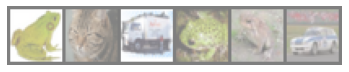

frog   cat    truck  frog   frog   automobile


In [3]:
def imshow(img, func=lambda x: x):
    img = func(img)
    img = img / 2 + 0.5
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, labels = next(iter(loader))

imshow(make_grid(images))
print(' '.join(f'{dataset.classes[labels[j]]:6}' for j in range(bs)))

## Task 1 (1.25p)
Implement a convolutional neural network for multiclass classification on CIFAR-10 from scratch. You need to implement both the model and the training loop. Your code should report the loss (during training and testing) and accuracy on the test set (optionally also on the training set). You should achieve 75% accuracy on the test set. You can use any features present in PyTorch.

Some tips:
- Change the runtime to GPU in Google Colab. You need to use `torch.device('cuda')` to train on the GPU (don't forget to send your model and data to the device!).
- Your model should inherit from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
- In order to have a short feedback loop, when choosing the architecture or hyperparameters don't train for more than a couple epochs.
- Visualize the loss curve to see when it begins to flatten and whether the model is overfitting (by comparing to the loss for the training set).

In [ ]:
# implement your model here
class Model(nn.Module):
    def __init__(self, bn=True):
        super(Model, self).__init__()
        
        self.bn = bn
        if bn:
            self.bn1 = nn.BatchNorm2d(num_features=48)
            self.bn2 = nn.BatchNorm2d(num_features=96)
            self.bn3 = nn.BatchNorm2d(num_features=192)
            self.bn4 = nn.BatchNorm2d(num_features=256)
        else:
            self.bn1 = lambda x: x
            self.bn2 = lambda x: x
            self.bn3 = lambda x: x
            self.bn4 = lambda x: x
            
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=8*8*256, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.Dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # 32*32*48
        x = F.relu(self.bn2(self.conv2(x))) # 32*32*96
        x = self.pool(x) # 16*16*96
        x = self.Dropout(x)
        x = F.relu(self.bn3(self.conv3(x))) # 16*16*192
        x = F.relu(self.bn4(self.conv4(x))) # 16*16*256
        x = self.pool(x) # 8*8*256
        x = self.Dropout(x)
        x = x.view(-1, 8*8*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.Dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
# load in the data here
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([ToTensor(), Normalize(cifar_mean, cifar_std)]))

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor(), Normalize(cifar_mean, cifar_std)]))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=2)

In [ ]:
# implement your training loop with all the needed hyperparameters here
# Epoch 20 | Progress: 99% | loss: 0.174	| Accuracy: 79.44
n_epochs = 20
batch_size = 64
log_interval = 100

device = torch.device('cuda')

net = Model()
net = net.to(device)

lr = 0.001
optimizer = optim.Adam(net.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    running_loss = 0.
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % log_interval == 0:
            progress = int(100 * (i + 1) * train_loader.batch_size / len(train_loader.dataset))
            print(f"\rEpoch {epoch + 1} | Progress: {progress}% | loss: {running_loss / log_interval:.3f}", end="")
            running_loss = 0.0

    with torch.no_grad():        
        correct = 0     
        for _, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                _ , predicted = torch.max(outputs, 1)
                correct += (outputs.argmax(1) == labels).sum().item()

    print(f'\t| Accuracy: {100 * correct / len(test_loader.dataset):.2f}')

## Data augmentation
Data augmentation is a technique to synthetically increase the amount of data by adding slightly modified copies of already existing data. The `torchvision` package contains many transformations useful for this task.

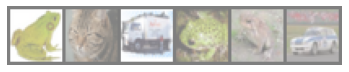

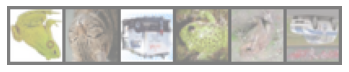

frog   cat    truck  frog   frog   automobile


In [4]:
from torchvision.transforms import RandomVerticalFlip

flip = RandomVerticalFlip(p=1) 

imshow(make_grid(images))
imshow(make_grid(images), flip)
print(' '.join(f'{dataset.classes[labels[j]]:6}' for j in range(bs)))

## Task 2 (0.25p)
Utilizing the functionality from [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) add augmentations to the training set and see how much that improves the accuracy of your model from the previous task. You can search the internet for typical augumentations for CIFAR-10.

In [ ]:
# load in the data with the augumentations here
from torchvision.transforms import RandomCrop, RandomHorizontalFlip

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([RandomCrop(32, padding=4), 
                                           RandomHorizontalFlip(p=0.5), 
                                           ToTensor(), 
                                           Normalize(cifar_mean, cifar_std)]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
# rerun the training loop from the previous task here
# Epoch 20 | Progress: 89% | loss: 0.368	| Accuracy: 84.73
for epoch in range(n_epochs):
    running_loss = 0.
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % log_interval == 0:
            progress = int(100 * (i + 1) * train_loader.batch_size / len(train_loader.dataset))
            print(f"\rEpoch {epoch + 1} | Progress: {progress}% | loss: {running_loss / log_interval:.3f}", end="")
            running_loss = 0.0

    with torch.no_grad():        
        correct = 0     
        for _, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                _ , predicted = torch.max(outputs, 1)
                correct += (outputs.argmax(1) == labels).sum().item()

    print(f'\t| Accuracy: {100 * correct / len(test_loader.dataset):.2f}')